# Predicting Ad Spending on Snapchat

## Cyril Gorlla
### University of California, San Diego

# Summary of Findings


### Introduction
This project is a follow up to the [previous](https://github.com/cgorlla/Snapchat-Ads/blob/master/Targeted%20Advertising%20in%20Snapchat%20Political%20Ads.ipynb) analysis of this dataset. The Snapchat ads dataset contains political ad data for ads on Snapchat, one of the largest social media networks in the world. A key feature of the dataset is how much money an organization spends on a particular ad, found in the `Spend` column. It is reasonable to assume that this amount varies based on certain factors, but can we use those factors to figure out how much is spent on an ad? We can explore this by predicting ad spending through machine learning. Specifically, we can utilize a regression model based on other features of the dataset to predict how much money will be spent on a particular ad. That is, we can use other columns of the dataset to predict the `Spend` column, our target variable, and we can evaluate our model's performance with $R^2$, or goodness of fit, so we can ascertain how well our model is replicating the outcomes observed in the data. $R^2$ is useful in telling us how effectively our model understands the patterns in the original data.

### Baseline Model
For our intial model, we choose to include six features: `Impressions` (quantitative), `StartMonth` (Ordinal), `StartDay` (Ordinal), `EndMonth` (Ordinal), `EndDay` (Ordinal), and `PayingAdvertiserName` (Nominal). The date-related features were chosen as there may be a correlation between the amount spent and what day or month the ad started or ended. The number of impressions is important as an ad with more impressions likely had a higher budget behind it. Lastly, the advertiser name (which was converted into one-hot encoding) may also be useful as certain advertisers may tend to spend more. We have a total of one quantitative, four ordinal, and one nominal feature(s). With this linear regression model, we achieve a $R^2$ of .66. This essentially means our model explains 66% of the variation in the original data. This is somewhat decent, but there is still a large portion of the data that the model is not understanding, so to speak, so there is definitely room for improvement.

### Final Model
We can improve our model by engineering two new features. Specifically, we can standardize the number of impressions by z-scoring, $z=(x-mean)/stddev.$ This yields data with a mean of 0 and a standard deviation of 1, better allowing us to see deviations from the mean number of impressions. Second, we can utilize Pandas' datetime functionality to calculate the difference in time from when the ad ended to when it started, giving us the total duration of the ad. It's reasonable to assume that the longer the duration of the ad, the more was spent on it, so this should be a useful feature in our model. We remove the other date features in favor of this feature. After trying various other regression models, it was determined that linear regression was still the best in terms of $R^2$, so this was chosen to be the final model. `GridSearchCV` was used to determine the optimal parameters for the linear regression model, these were `fit_intercept = True` and `normalize = False`. The other parameters of the model are unrelated to the actual model output. These were the default values for the model, so they were left unchanged. Our final model yielded a $R^2$ of .84, a large improvement from our previous model. This indicates that the new model replicates the outcomes of the observed data much better.

### Fairness Evaluation
We now wish to ascertain how well our model performs on certain portions of the data. Specifically, on those ads with low amounts of impressions. We define "low" as slightly lower than the 25th percentile, 18,000 impressions. To determine how fair our model is to ads with lower impressions vs. regular and higher impressions, we separate the dataset into two, one with ads with low impressions as defined above and one with the rest of the ads. We then see how well the model performs on various permutations of each subset to get a clearer picture of its fairness to ads with low vs other amounts of impressions. We use $\alpha$ = 0.1 with the null hypothesis that the model treats both the same in terms of $R^2$ and the alternative hypothesis being that it treats ads with low impressions more poorly with a lower $R^2$. The model has an average $R^2$ of .45 on the low dataset but .72 on the rest of the data. Using the Kolmogorov–Smirnov test, we can compare the distributions of the scores of the model for both subsets of the data. We have an extremely small p-value of $3.65* 10^{-153}$, so we reject the null hypothesis and determine that the model is likely unfair in that it performs worse on ads with lower impressions.

# Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.pipeline import *
from sklearn.compose import *
import scipy.stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Baseline Model

In [ ]:
#currency was converted and months/days were added in previous project
sc = pd.read_csv('sc.csv').drop('Unnamed: 0',axis=1)
#we drop null values, the only null values are in EndMonth/Day
base = sc[['Impressions','StartMonth','StartDay','EndMonth','EndDay','PayingAdvertiserName','Spend']].dropna()
#select the columns we want to use

In [ ]:
# Numeric columns and associated transformers
num_feat = ['Impressions']
num_transformer = Pipeline(steps=[
    ('passthrough', FunctionTransformer(lambda x:x))   # passthrough
])

# Categorical columns and associated transformers
cat_feat = ['StartMonth','StartDay','EndMonth','EndDay','PayingAdvertiserName']
cat_transformer = Pipeline(steps=[
    ('intenc', OrdinalEncoder()),   # converts to int
    ('onehot', OneHotEncoder())     # output from Ordinal becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('regressor',LinearRegression())])

In [ ]:
X = preproc.fit_transform(base.drop('Spend', axis=1)) #process the dataset
y = base.Spend

In [437]:
score = []
for x in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    score.append(pl.score(X_test, y_test))
print(np.mean(score)) #average R^2

0.6611158867619407


### Final Model

In [ ]:
# Numeric columns and associated transformers
num_feat = ['Impressions']
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())   # z-scale impressions
])

def get_hours(x):
    df = pd.to_datetime(x['EndDate']).dt.hour - pd.to_datetime(x['StartDate']).dt.hour
    return pd.DataFrame(df)
dates = ['StartDate','EndDate']
date_transformer = Pipeline(steps=[
    ('duration', FunctionTransformer(get_hours))
    #time duration
])

# Categorical columns and associated transformers
cat_feat = ['PayingAdvertiserName']
cat_transformer = Pipeline(steps=[
    ('intenc', OrdinalEncoder()),   # converts to int
    ('onehot', OneHotEncoder())     # output from Ordinal becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc2 = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('dates',date_transformer,dates), ('cat', cat_transformer, cat_feat)])

pl2 = Pipeline(steps=[('regressor', LinearRegression())])

In [ ]:
#select features for new model
improved = sc[['Impressions','StartDate','EndDate','PayingAdvertiserName','Spend']].dropna()

In [420]:
#get parameters to optimize
pl2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'regressor', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__n_jobs', 'regressor__normalize'])

In [423]:
params = {'regressor__fit_intercept': [True, False], 'regressor__normalize': [True, False]}
grids = GridSearchCV(pl2, param_grid=params, cv=5)

In [424]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y)
grids.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False],
                         'regressor__normalize': [True, False]})

In [425]:
grids.best_params_ #these are the defaults

{'regressor__fit_intercept': True, 'regressor__normalize': False}

In [426]:
grids.best_score_

0.7636818802834835

In [532]:
X = preproc2.fit_transform(improved.drop('Spend', axis=1)) #process the dataset
y = improved.Spend
score = []
for x in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl2.fit(X_train, y_train)
    score.append(pl2.score(X_train, y_train))
print(np.mean(score)) #R^2

0.8493351530307777


### Fairness Evaluation

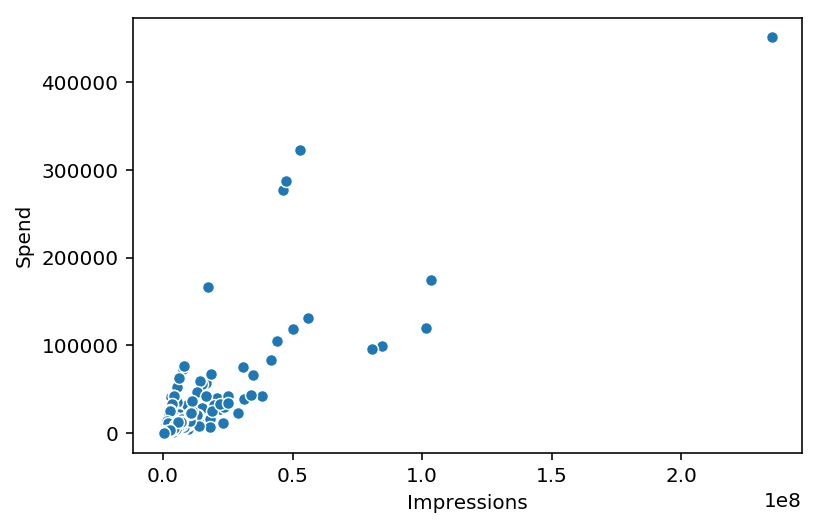

In [460]:
sns.scatterplot(improved['Impressions'],improved['Spend'])
#There is some correlation between spend and impressions

In [461]:
improved[['Impressions']].describe()
#what if we looked at ads with low impressions, below the 25%?

,Impressions
count,4.184000e+03
mean,9.269965e+05
std,5.490533e+06
min,1.000000e+00
25%,1.851525e+04
50%,1.017510e+05
75%,4.533338e+05
max,2.349018e+08


In [536]:
improved['Binarized'] = Binarizer(threshold=18000).fit_transform(improved[['Impressions']])

In [555]:
improved.head(10)

,Impressions,StartDate,EndDate,PayingAdvertiserName,Spend,Binarized
0,1183287,2019/09/27 12:29:18Z,2019/10/05 14:00:00Z,Federal National Council,4187.000000,1
1,190847,2019/03/20 13:00:00Z,2019/04/04 03:59:59Z,Ben & Jerry's,1576.000000,1
2,84687140,2019/10/23 13:00:00Z,2019/11/16 07:59:59Z,"Recreational Equipment, Inc.",99361.000000,1
3,2555940,2019/09/30 14:00:00Z,2020/06/29 03:59:00Z,truth,10360.000000,1
4,323890,2019/06/03 07:00:00Z,2019/09/04 06:59:59Z,Plan International Canada,260.219623,1
5,3231,2019/11/26 00:05:10Z,2019/11/26 23:00:00Z,HOPE not hate Charitable Trust,7.760268,0
6,2762599,2019/11/12 13:11:17Z,2019/11/18 23:59:59Z,The Labour Party,6466.890193,1
7,8779,2019/09/13 09:32:01Z,2019/09/14 09:32:01Z,NCDHD,23.000000,0
8,2585,2019/12/13 00:29:58Z,2020/01/01 04:59:59Z,Warren for President,48.000000,0
9,50946,2019/10/17 20:09:20Z,2019/11/06 00:00:00Z,ACRONYM,365.000000,1


In [538]:
#separate data
low = df[improved['Binarized'] == 0]
rest = df[improved['Binarized'] == 1]

In [541]:
X_low = (preproc2.fit_transform(low.drop('Spend', axis=1)))
y_low = low.Spend
score_low = []
for x in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X_low, y_low)
    score_low.append(pl2.score(X_test, y_test))
print(np.mean(score_low)) #low R^2

0.4502236073057152


In [542]:
X_rest = (preproc2.fit_transform(rest.drop('Spend', axis=1)))
y_rest = rest.Spend
score_rest = []
for x in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest)
    score_rest.append(pl2.score(X_test, y_test))
print(np.mean(score_rest)) #higher R^2

0.7288819175587933


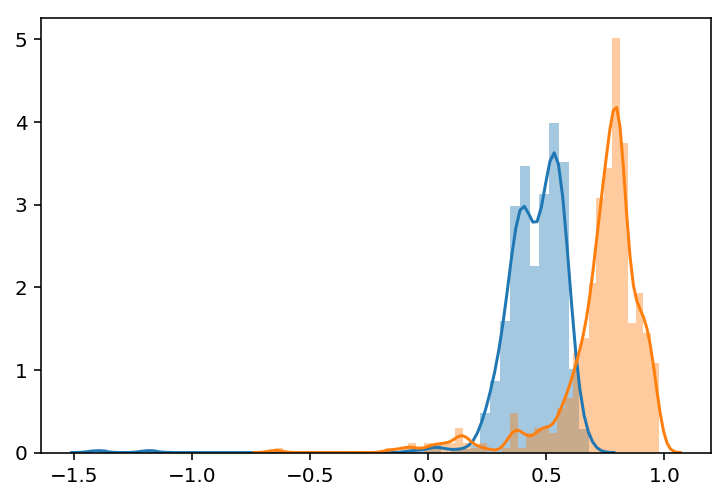

In [558]:
sns.distplot(score_low)
sns.distplot(score_rest)

In [544]:
scipy.stats.ks_2samp(score_low,score_rest) #very low P-val, dist. are not similar

Ks_2sampResult(statistic=0.832, pvalue=3.6552424432544507e-153)